# Install all necessary packages

In [ ]:
!pip install keras-ocr
!pip install matplotlib
!pip install opencv-python

# Import all necessary libraries

In [1]:
import math, keras_ocr

# Define image path

In [2]:
#image_path = 'images/disney.png'
#image_path = 'images/frost.png'
#image_path = 'images/hughes.png'
image_path = 'images/wanderer.png'

# Display image

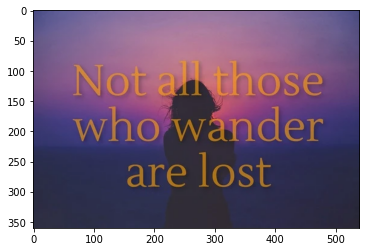

In [3]:
import cv2
import matplotlib.pyplot as plt

# Plot...
original_image = cv2.imread(image_path)
original_image = original_image[:, :, ::-1]
plt.imshow(original_image)

# Get Raw Detections...

In [4]:
# Initialize pipeline
pipeline = keras_ocr.pipeline.Pipeline()

# Read in image
read_image = keras_ocr.tools.read(image_path)

# prediction_groups is a list of (word, box) tuples
prediction_groups = pipeline.recognize([read_image]) 

Looking for /Users/elliekuang/.keras-ocr/craft_mlt_25k.h5


2022-10-24 17:26:43.388732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Looking for /Users/elliekuang/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


# Show image with annotation and boxes

<AxesSubplot:>

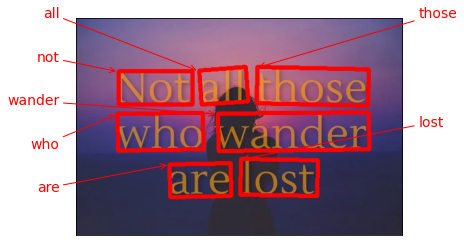

In [5]:
keras_ocr.tools.drawAnnotations(image=read_image, predictions=prediction_groups[0])

# Without my code...

In [6]:
raw_detections = []
for prediction in prediction_groups[0]:
    raw_detections.append(prediction[0])
print(f'Detections: {raw_detections}') # out of order

Detections: ['those', 'all', 'not', 'wander', 'who', 'lost', 'are']


# Goal is to return results that read from top to bottom and then left to right (like a human)

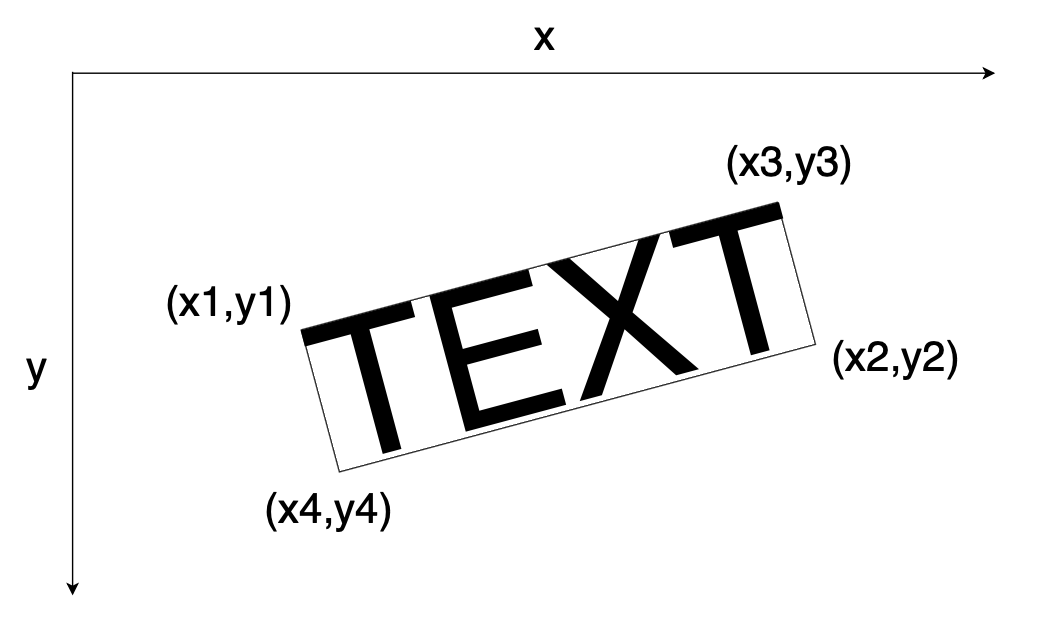

## Get all centers of predictions from prediction_groups[0]

In [7]:
def get_distance(predictions):
    """ 
    Function returns dictionary with (key,value):
        * text : detected text in image
        * center_x : center of bounding box (x)
        * center_y : center of bounding box (y)
        * distance_from_origin : hypotenuse
        * distance_y : distance between y and origin (0,0)
    """

    # Point of origin
    x0, y0 = 0, 0 

    # Generate dictionary
    detections = []
    for group in predictions:
    
        # Get center point of bounding box
        top_left_x, top_left_y = group[1][0]
        bottom_right_x, bottom_right_y = group[1][1]
        center_x, center_y = (top_left_x + bottom_right_x)/2, (top_left_y + bottom_right_y)/2

        # Use the Pythagorean Theorem to solve for distance from origin
        distance_from_origin = math.dist([x0,y0], [center_x, center_y])

        # Calculate difference between y and origin to get unique rows
        distance_y = center_y - y0

        # Append all results
        detections.append({
                            'text': group[0],
                            'center_x': center_x,
                            'center_y': center_y,
                            'distance_from_origin': distance_from_origin,
                            'distance_y': distance_y
                        })

    return detections

In [8]:
predictions = prediction_groups[0] # extract text list
predictions = get_distance(predictions)
predictions

[{'text': 'those',
  'center_x': 391.6681823730469,
  'center_y': 84.64476013183594,
  'distance_from_origin': 400.71024506641,
  'distance_y': 84.64476013183594},
 {'text': 'all',
  'center_x': 241.81285095214844,
  'center_y': 85.4218521118164,
  'distance_from_origin': 256.45730191168076,
  'distance_y': 85.4218521118164},
 {'text': 'not',
  'center_x': 131.0,
  'center_y': 89.0,
  'distance_from_origin': 158.3729774930054,
  'distance_y': 89.0},
 {'text': 'wander',
  'center_x': 359.1632385253906,
  'center_y': 158.3188018798828,
  'distance_from_origin': 392.5086940906255,
  'distance_y': 158.3188018798828},
 {'text': 'who',
  'center_x': 139.14845275878906,
  'center_y': 159.00938415527344,
  'distance_from_origin': 211.2966543857339,
  'distance_y': 159.00938415527344},
 {'text': 'lost',
  'center_x': 335.94659423828125,
  'center_y': 235.58131408691406,
  'distance_from_origin': 410.31532962737043,
  'distance_y': 235.58131408691406},
 {'text': 'are',
  'center_x': 205.07461547

# Distinguish Rows

In [9]:
def distinguish_rows(lst, thresh=15):
    """Function to help distinguish unique rows"""
    sublists = []
    for i in range(0, len(lst)-1):
        if (lst[i+1]['distance_y'] - lst[i]['distance_y'] <= thresh):
            if lst[i] not in sublists:
                sublists.append(lst[i])
            sublists.append(lst[i+1])
        else:
            yield sublists
            sublists = [lst[i+1]]
    yield sublists

In [10]:
# Set thresh higher for text further apart
predictions = list(distinguish_rows(predictions, thresh=15))
predictions

[[{'text': 'those',
   'center_x': 391.6681823730469,
   'center_y': 84.64476013183594,
   'distance_from_origin': 400.71024506641,
   'distance_y': 84.64476013183594},
  {'text': 'all',
   'center_x': 241.81285095214844,
   'center_y': 85.4218521118164,
   'distance_from_origin': 256.45730191168076,
   'distance_y': 85.4218521118164},
  {'text': 'not',
   'center_x': 131.0,
   'center_y': 89.0,
   'distance_from_origin': 158.3729774930054,
   'distance_y': 89.0}],
 [{'text': 'wander',
   'center_x': 359.1632385253906,
   'center_y': 158.3188018798828,
   'distance_from_origin': 392.5086940906255,
   'distance_y': 158.3188018798828},
  {'text': 'who',
   'center_x': 139.14845275878906,
   'center_y': 159.00938415527344,
   'distance_from_origin': 211.2966543857339,
   'distance_y': 159.00938415527344}],
 [{'text': 'lost',
   'center_x': 335.94659423828125,
   'center_y': 235.58131408691406,
   'distance_from_origin': 410.31532962737043,
   'distance_y': 235.58131408691406},
  {'text': 

In [11]:
# Remove all empty rows
predictions = list(filter(lambda x:x!=[], predictions))

# With my code...

In [12]:
# Order text detections in human readable format
ordered_preds = []
for row in predictions:
    row = sorted(row, key=lambda x:x['distance_from_origin'])
    for each in row: ordered_preds.append(each['text'])
print(f'Detections: {ordered_preds}')

Detections: ['not', 'all', 'those', 'who', 'wander', 'are', 'lost']


In [13]:
# Join detections into sentence
' '.join(ordered_preds)

'not all those who wander are lost'